# More Fisher information exploration

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns
import plotly.express as px

import numpy as np
import pandas as pd
import polars as pl

import statsmodels.formula.api as smf

import torch

In [2]:
# load the trained model
from datageneration.stimulusGeneration import generateGrating
from basicModel import EstimateAngle

from experiments.ex2_sensitivity_scaling import dataFile_Experiment2

# training data parameters
pixelDim = 101
shotNoise = 0.8
noiseVar = 20

# training data distribution
dataSize = 512
kappa_tr = 4.
loc_tr = 0.
rep = 0


fileName = dataFile_Experiment2(dataSize, kappa_tr, loc_tr, rep)
trained_model = EstimateAngle.load_from_checkpoint(fileName)

In [3]:
fileName

'trainedParameters/Experiment2/380931818027565204/epoch=208-step=26752.ckpt'

## Full derivatives

In [3]:
# different derivative techniques
from scipy.interpolate import splev, splrep, splprep
from scipy.signal import savgol_filter
from tvregdiff.tvregdiff import TVRegDiff


In [4]:
angles = np.linspace(0, np.pi, 10000)

noisy_results = trained_model.forward(
                            generateGrating(angles, pixelDim=pixelDim, shotNoise=shotNoise,
                                            noiseVar=noiseVar)
                    ).detach().numpy()

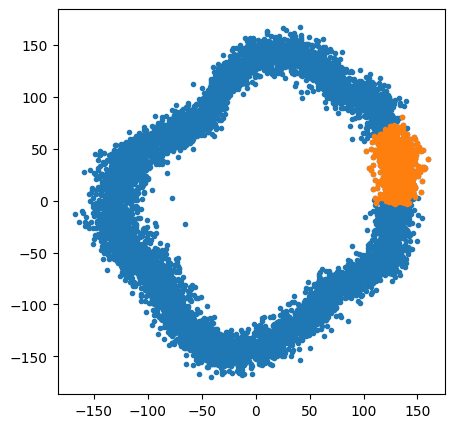

In [5]:
figsize(5,5)
plt.plot(noisy_results[:,0], noisy_results[:,1], '.')
plt.plot(noisy_results[0:800, 0], noisy_results[0:800, 1], '.')

In [6]:
fits0 = savgol_filter(noisy_results[:,0], window_length=400, polyorder=2, mode='wrap')
fits1 = savgol_filter(noisy_results[:,1], window_length=400, polyorder=2, mode='wrap')

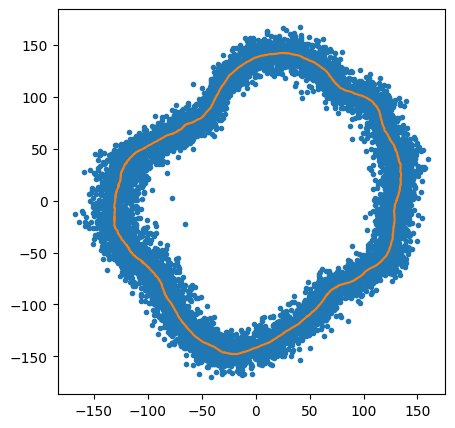

In [7]:
plt.plot(noisy_results[:,0], noisy_results[:,1], '.')
plt.plot(fits0, fits1)

In [8]:
derivs0 = savgol_filter(noisy_results[:,0], window_length=300, polyorder=2, deriv=1, mode='wrap', delta=angles[1]-angles[0])
derivs1 = savgol_filter(noisy_results[:,1], window_length=300, polyorder=2, deriv=1, mode='wrap', delta=angles[1]-angles[0])

derivs0_larger = savgol_filter(noisy_results[:,0], window_length=400, polyorder=2, deriv=1, mode='wrap', delta=angles[1]-angles[0])
derivs1_larger = savgol_filter(noisy_results[:,1], window_length=400, polyorder=2, deriv=1, mode='wrap', delta=angles[1]-angles[0])

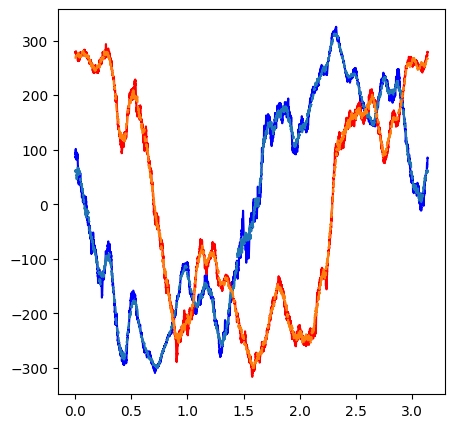

In [9]:
plt.plot(angles, derivs0, 'b')
plt.plot(angles, derivs1, 'r')

plt.plot(angles, derivs0_larger, '--')
plt.plot(angles, derivs1_larger, '--')

These certainly seem good enough. It'd be nice to confirm that they at least line up with another method.

In [10]:
splinerep, u = splprep([noisy_results[:,0], noisy_results[:,1]], u=angles, s=990000)

In [11]:
a, b = splev(np.linspace(0, np.pi, 2000), splinerep)

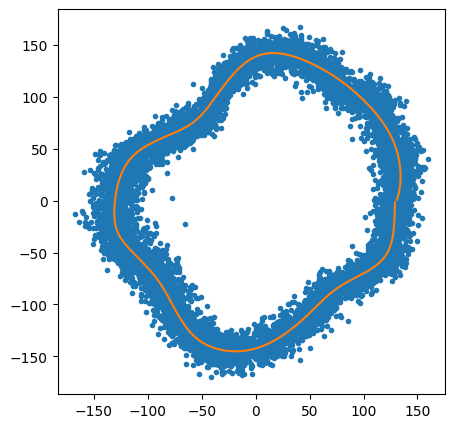

In [12]:
plt.plot(noisy_results[:,0], noisy_results[:,1], '.')
plt.plot(a,b)

On point for the savgol filter: spline fits are sloooow

In [13]:
theta_eval = np.linspace(0, np.pi, 2000)
spline_derivs = splev(theta_eval, splinerep, der=1)

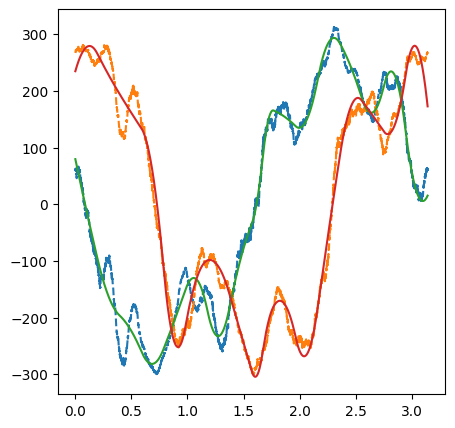

In [14]:
plt.plot(angles, derivs0_larger, '--')
plt.plot(angles, derivs1_larger, '--')

plt.plot(theta_eval, spline_derivs[0])
plt.plot(theta_eval, spline_derivs[1])


Broadly speaking, they do agree. The Savgol, of course has some additional structure around the spline. 

In [15]:
derivs0_verysmooth = savgol_filter(noisy_results[:,0], window_length=700, polyorder=2, deriv=1, mode='wrap', delta=angles[1]-angles[0])
derivs1_verysmooth = savgol_filter(noisy_results[:,1], window_length=700, polyorder=2, deriv=1, mode='wrap', delta=angles[1]-angles[0])

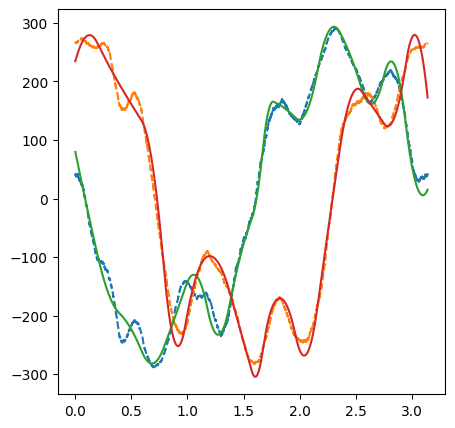

In [16]:
plt.plot(angles, derivs0_verysmooth, '--')
plt.plot(angles, derivs1_verysmooth, '--')

plt.plot(theta_eval, spline_derivs[0])
plt.plot(theta_eval, spline_derivs[1])

Yeah, we can always smooth more. Good enough.

## Now the covariances

In [48]:
angles = np.linspace(0, np.pi, 500)

covs = []
for angle in angles:
    noisy_results = trained_model.forward(
                                generateGrating(5000*[angle], pixelDim=pixelDim, shotNoise=shotNoise,
                                                noiseVar=noiseVar)
                        ).detach().numpy()

    print(angle)
    
    covs.append(np.cov(noisy_results.T))

0.0
0.006295776860901389
0.012591553721802777
0.018887330582704167
0.025183107443605555
0.031478884304506946
0.037774661165408334
0.04407043802630972
0.05036621488721111
0.0566619917481125
0.06295776860901389
0.06925354546991527
0.07554932233081667
0.08184509919171805
0.08814087605261944
0.09443665291352082
0.10073242977442222
0.10702820663532361
0.113323983496225
0.11961976035712639
0.12591553721802778
0.13221131407892917
0.13850709093983055
0.14480286780073193
0.15109864466163334
0.15739442152253472
0.1636901983834361
0.1699859752443375
0.1762817521052389
0.18257752896614027
0.18887330582704165
0.19516908268794306
0.20146485954884444
0.20776063640974582
0.21405641327064723
0.2203521901315486
0.22664796699245
0.23294374385335137
0.23923952071425278
0.24553529757515416
0.25183107443605557
0.25812685129695695
0.26442262815785833
0.2707184050187597
0.2770141818796611
0.2833099587405625
0.28960573560146385
0.2959015124623653
0.30219728932326667
0.30849306618416805
0.31478884304506943
0.32

In [58]:
cp = (covs[2] - covs[0]) / ( angles[2] - angles[0])

In [61]:
np.trace( cp @ np.linalg.inv(covs[1]) @ cp @ np.linalg.inv(covs[1]))

84.8396206758675

Ok, so the contribution from changing covariance is not small

In [65]:
deriv = np.array([derivs0_verysmooth[1], derivs1_verysmooth[1]])

In [85]:
deriv.T @ np.linalg.inv(covs[1]) @ deriv

8908.307093829468

But in comparison the derivative term...

In [70]:
derivs0_verysmooth.shape

(10000,)

In [78]:
angles_deriv = np.linspace(0, np.pi, 10000)
angles_cov = np.linspace(0, np.pi, 500)

In [79]:
angles_cov[1]

0.006295776860901389

In [83]:
angles_deriv[20]

0.006283813688548441

In [112]:
deriv_cov_ratio = 10000 // 500

derivs =  np.array( [derivs0_verysmooth, derivs1_verysmooth])

def make_Fisher_Info(derivs, covs, deriv_cov_ratio=deriv_cov_ratio):
    """ """
    FI = []
    for i, cov in enumerate(covs):
        FI.append(derivs[:, deriv_cov_ratio*i] @ np.linalg.inv(cov) @ derivs[:, deriv_cov_ratio*i])

    return np.array(FI)


In [113]:
FI = make_Fisher_Info(derivs, covs)

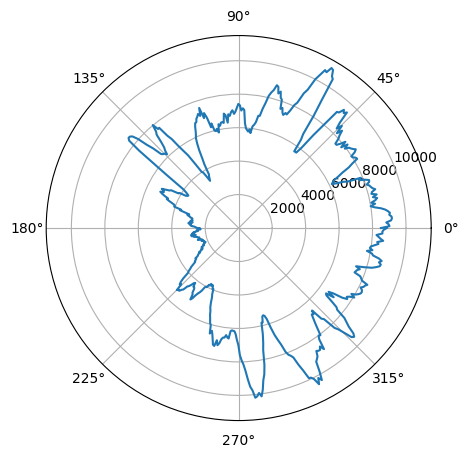

In [114]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.plot(2*angles_cov, FI)


Ok. First of all, this is pretty consistent with the previous estimate in Experiments 3. The main question is: how successful were we in decreasing the variance?

Also: how do the different Fisher information measurement techniques compare to one-another.

